## Step 0: Import Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statistics import mean
from sklearn.model_selection import train_test_split
import joblib 
import lightgbm as lgb
from xgboost import XGBRegressor
from prophet import Prophet
# from fbprophet import Prophet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold


## STEP 1. LOOK AT THE BIG PICTURE (DONE)

## STEP 2. GET THE DATA (DONE). LOAD DATA

In [25]:
raw_data = pd.read_csv(r'dataset/Data.csv')
# raw_data.head(10) preview the first 10 column
#raw_data.tail() preview the last 10 column 

## STEP 3. DISCOVER THE DATA TO GAIN INSIGHTS

Function for plotting data for each year

In [26]:
# Function to plot the data for each year
def plot_year_data(year):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx()  # Create a secondary axis for the bar chart

    # Plot temperature and feels like as line charts
    ax.plot(monthly_avg.index, monthly_avg['temp'][year], label=f'Temp {year}', color='red')
    ax.plot(monthly_avg.index, monthly_avg['feelslike'][year], label=f'Feels Like {year}', color='red', linestyle='dashed')

    # Plot precipitation as a bar chart
    ax2.bar(monthly_avg.index, monthly_avg['precip'][year], color='blue', alpha=0.3, label=f'Precip {year}')

    # Set the axis labels and title
    ax.set_title(f'Temperature, Feels Like, and Precipitation in {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature (°C)', color='red')
    ax2.set_ylabel('Precipitation (mm)', color='blue')

    # Set custom month labels on the x-axis
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(months)

    # Add legends outside of the plot area, further right
    ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.85))

    # Grid for better readability
    ax.grid(True)

    # Adjust layout and leave space for the legends
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1694 entries, 0 to 1693
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1694 non-null   object 
 1   datetime          1694 non-null   object 
 2   tempmax           1694 non-null   float64
 3   tempmin           1694 non-null   float64
 4   temp              1694 non-null   float64
 5   feelslikemax      1694 non-null   float64
 6   feelslikemin      1694 non-null   float64
 7   feelslike         1694 non-null   float64
 8   dew               1694 non-null   float64
 9   humidity          1694 non-null   float64
 10  precip            1694 non-null   float64
 11  precipprob        1694 non-null   int64  
 12  precipcover       1694 non-null   float64
 13  preciptype        1238 non-null   object 
 14  snow              1694 non-null   int64  
 15  snowdepth         1694 non-null   int64  
 16  wi

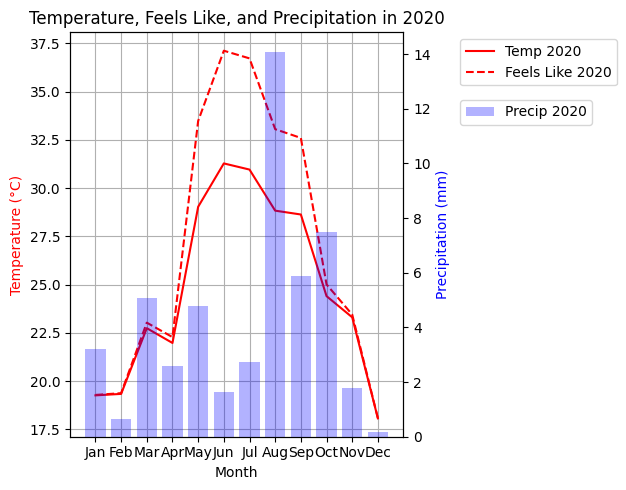

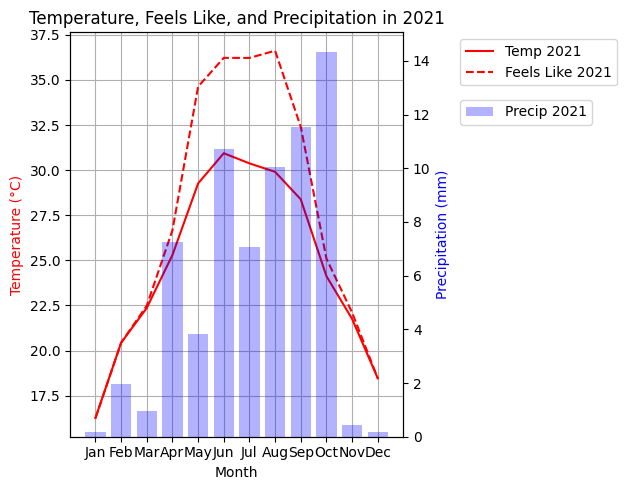

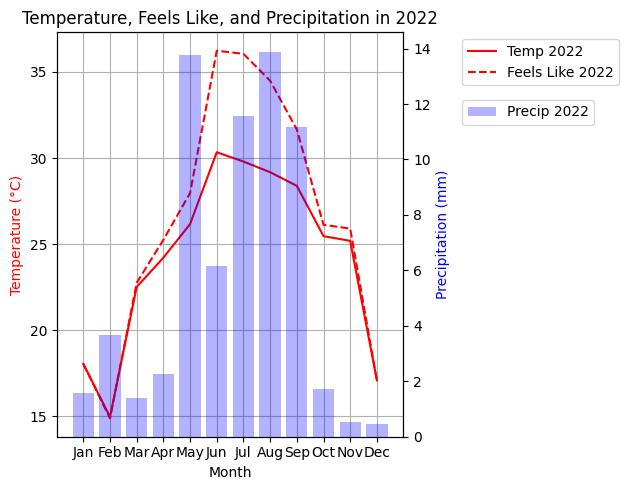

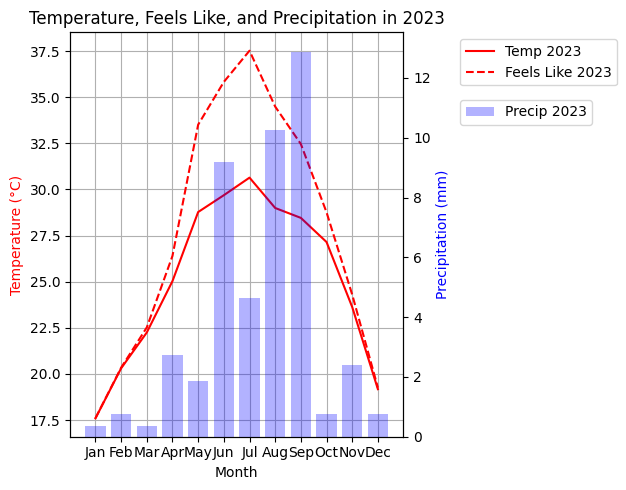

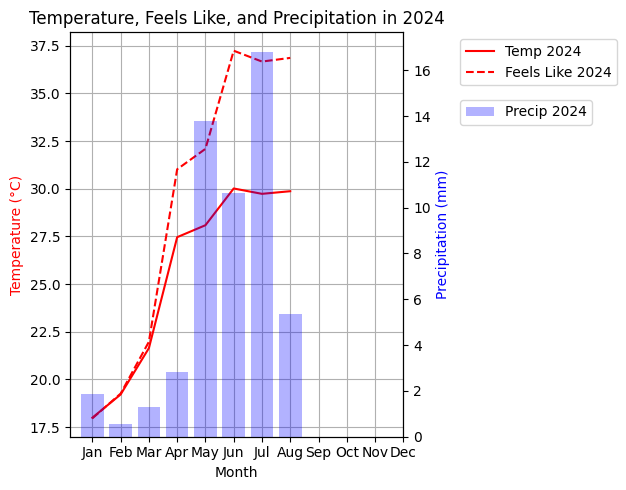

In [27]:
# 3.1 Quick view of the data
print('\n____________ Dataset info ____________')
print(raw_data.info())              
print('\n____________ Some first data examples ____________')
print(raw_data.head(5)) 
print('\n____________ Counts on a feature ____________')
# print(raw_data['LEGAL DOCUMENTS'].value_counts()) 
print('\n____________ Statistics of numeric features ____________')
print(raw_data.describe())    
print('\n____________ Get specific rows and cols ____________')     
print(raw_data.iloc[[0,1,45], [2, 5]] ) # Refer using column ID


# Convert 'datetime' column to pandas datetime
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])

# Extract the year from the 'datetime' column into a new 'year' column
raw_data['year'] = raw_data['datetime'].dt.year

# Filter data for the years 2020 to 2024
years = [2020, 2021, 2022, 2023, 2024]
filtered_data = raw_data[raw_data['year'].isin(years)]

# Group the data by year and month, and calculate the average temp, feels like, and precip for each month
monthly_avg = filtered_data.groupby([filtered_data['datetime'].dt.month, filtered_data['datetime'].dt.year])[['temp', 'feelslike', 'precip']].mean().unstack(1)

# Define month names for the x-axis
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot the data for each year separately (2020 to 2023)
for year in years[:-1]:  # Exclude 2024
    plot_year_data(year)

# Plot the data for 2024 in a separate figure
plot_year_data(2024)


## Step 4: Prepare the data


4.1 Find features(based on MI) that related to the target label

In [28]:
# Load the dataset
file_path = 'dataset/Data.csv'  # Adjust the path to your dataset
data = pd.read_csv(file_path)

# Select only the numeric columns from the dataset
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data_numeric = data[numeric_cols]

# Drop rows with missing values (NaN) in the numeric dataset
data_numeric_cleaned = data_numeric.dropna()

# Prepare the feature set (all numeric features except `temp`)
X = data_numeric_cleaned.drop(columns=['temp', 'severerisk', 'precipprob'])  # Drop 'temp' (target variable)
y = data_numeric_cleaned['temp']  # Target variable

# Step 1: Calculate Mutual Information
mi = mutual_info_regression(X, y)

# Create a DataFrame for mutual information
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi
}).sort_values(by='Mutual Information', ascending=False)

# Print mutual information
print("Mutual Information between Features and Target:")
print(mi_df)

# Step 2: Select top features based on MI (lấy tất cả những chỉ số MI trên 0.25)
top_features = mi_df['Feature'].head(8).values ## Có 10 chỉ số MI trên 0.25
print(f"Top features correlate to feature 'temp' based on MI: {top_features}")

Mutual Information between Features and Target:
             Feature  Mutual Information
4          feelslike            3.192120
2       feelslikemax            1.587806
0            tempmax            1.582170
1            tempmin            1.421827
3       feelslikemin            1.389786
5                dew            1.007704
14  sealevelpressure            0.690802
6           humidity            0.308469
17    solarradiation            0.304529
18       solarenergy            0.299732
15        cloudcover            0.298708
16        visibility            0.282857
19           uvindex            0.241714
13           winddir            0.190744
7             precip            0.118547
8        precipcover            0.080759
11          windgust            0.067871
12         windspeed            0.027598
20         moonphase            0.026447
10         snowdepth            0.004329
9               snow            0.003676
Top features correlate to feature 'temp' based on 

4.1.1. Drop columns

In [29]:
# List of features to keep
features_to_keep = ['feelslike', 'tempmax', 'feelslikemax', 'tempmin', 'feelslikemin', 'dew',
                     'sealevelpressure', 'humidity', 'temp']

# Drop columns that are not in the list of features to keep
raw_data = raw_data[features_to_keep]
print("Dropped columns successfully. Feature to keeps: ", features_to_keep)
# print(raw_data.head())

Dropped columns successfully. Feature to keeps:  ['feelslike', 'tempmax', 'feelslikemax', 'tempmin', 'feelslikemin', 'dew', 'sealevelpressure', 'humidity', 'temp']


4.2 Split-training the dataset:

In our regression problem, Stratified Sampling is not necessary because the features and target values are continuous rather than categorical. Stratified Sampling is typically used in classification problems to maintain the distribution of target classes across datasets. In regression, where the goal is to predict continuous values, maintaining class proportions is irrelevant and does not impact the model's performance. Therefore, I will focus on data normalization and model optimization to enhance prediction accuracy.

In [30]:
# Split the data into training and test sets
train_set, test_set = train_test_split(raw_data, test_size=0.2, random_state=42)  # Set random_state to get the same training set each time, 
                                                                                     # otherwise, when repeating training many times, your model might see all the data
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(4))


____________ Split training and test set ____________
1355 training + 339 test examples
      feelslike  tempmax  feelslikemax  tempmin  feelslikemin   dew  \
1386       28.9     32.5          35.1     22.5          22.5  20.8   
752        18.4     21.4          21.4     16.0          16.0  17.3   
408        19.3     22.0          22.0     17.0          17.0  14.5   
1401       26.6     30.5          32.2     22.0          22.0  20.5   

      sealevelpressure  humidity  temp  
1386            1012.5      68.3  27.6  
752             1011.1      93.5  18.4  
408             1017.1      74.4  19.3  
1401            1014.2      73.9  25.9  


4.3 Separate labels from data, since we do not process label values (already processed)

In [31]:
# Separate labels from data
X_train = train_set.drop(columns=['temp'])
y_train = train_set['temp']
X_test = test_set.drop(columns=['temp'])
y_test = test_set['temp']

4.4. Define pipelines for processing data.

4.4.1. Define ColumnSelector: a transformer for choosing columns

In [32]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    # Hàm khởi tạo nhận vào danh sách các tên cột cần chọn
    def __init__(self, feature_names):
        self.feature_names = feature_names  # Lưu trữ danh sách tên cột

    # Phương thức fit không cần thực hiện gì, chỉ trả về chính đối tượng này
    # để tương thích với quy trình của scikit-learn
    def fit(self, dataframe, labels=None):
        return self

    # Phương thức transform chọn các cột từ DataFrame dựa trên danh sách tên cột
    # và trả về các giá trị dưới dạng mảng NumPy
    def transform(self, dataframe):
        return dataframe[self.feature_names].values  # Chọn và trả về các cột dưới dạng mảng NumPy


In [33]:
#numerical features
num_feat_names = ['feelslike', 'tempmax', 'feelslikemax', 'tempmin', 'feelslikemin', 'dew', 'sealevelpressure', 'humidity']

4.4.2.Pipeline for categorical features (IN OUR TRAINING AND TESTING DATASET, THERE ARE NO CATEGORICAL FEATURES)

4.4.3. KHÔNG CẦN LÀM BƯỚC NÀY

4.4.4. Pipeline for numerical features

In [34]:
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', ColumnSelector(num_feat_names)),  # Chọn các cột numeric
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),  # Điền giá trị thiếu bằng median
    ('std_scaler', StandardScaler(with_mean=True, with_std=True))  # Chuẩn hóa về zero mean và unit variance
])

4.4.5 Run the pipeline to process training data

In [35]:
processed_train_set_val = num_pipeline.fit_transform(train_set)

print('\n____________ Processed feature values ____________')
print(processed_train_set_val[:3, :])  # In ra một vài hàng đầu tiên sau khi xử lý
print(processed_train_set_val.shape)  # In ra kích thước của dữ liệu đã xử lý
joblib.dump(num_pipeline, r'models/num_pipeline.pkl')   # Lưu pipeline vào file


____________ Processed feature values ____________
[[ 0.2188158   0.69734126  0.29538826  0.13606056 -0.02198708  0.10070735
   0.17627356 -0.85735425]
 [-1.12725897 -1.16977897 -1.13691767 -1.16734748 -1.06705571 -0.49170722
  -0.02275682  1.46528313]
 [-1.01188114 -1.06885355 -1.07418894 -0.96682316 -0.90627592 -0.96563888
   0.83023053 -0.29512854]]
(1355, 8)


['models/num_pipeline.pkl']

LƯU Ý: Các giá trị âm trong processed_train_set_val là hoàn toàn hợp lý và thường gặp trong các bài toán học máy, đặc biệt là khi bạn sử dụng chuẩn hóa (scaling) như StandardScaler. Đây là một số lý do và cách giải thích:

1. Chuẩn hóa (Standardization):
StandardScaler: Bạn đã sử dụng StandardScaler trong pipeline của mình. StandardScaler chuẩn hóa các đặc trưng bằng cách trừ giá trị trung bình và chia cho độ lệch chuẩn, để các đặc trưng có phân phối chuẩn với trung bình bằng 0 và độ lệch chuẩn bằng 1.
Kết quả: Sau khi chuẩn hóa, một số giá trị có thể âm, điều này hoàn toàn bình thường. Nếu một giá trị của đặc trưng thấp hơn trung bình của đặc trưng đó, sau khi chuẩn hóa, giá trị đó có thể âm.
2. Giá trị âm trong Dữ liệu:
Cột dữ liệu: Nếu dữ liệu gốc có giá trị âm (ví dụ như áp suất không khí có thể có giá trị âm trong một số hệ thống đo lường), thì sau khi chuẩn hóa, các giá trị đó có thể vẫn còn âm.
3. Ý Nghĩa của Giá trị Âm:
Ký hiệu của Chuẩn hóa: Giá trị âm trong kết quả chuẩn hóa chỉ ra rằng giá trị gốc của đặc trưng đó thấp hơn trung bình của đặc trưng đó trong tập dữ liệu. Điều này không có nghĩa là dữ liệu có vấn đề, mà chỉ đơn giản là nó ở dưới mức trung bình.
4. Ví dụ:
Nếu một đặc trưng X có giá trị trung bình là 100 và độ lệch chuẩn là 15, thì giá trị chuẩn hóa được tính theo công thức: 
𝑍
=
𝑋
−
mean
std
Z= 
std
X−mean
​
 

Nếu X = 85, thì: 
𝑍
=
85
−
100
15
=
−
1
Z= 
15
85−100
​
 =−1
Giá trị chuẩn hóa -1 là hợp lý và có thể xảy ra.
Tóm lại:
Giá trị âm trong processed_train_set_val là một kết quả bình thường của việc chuẩn hóa dữ liệu và phản ánh sự phân bố dữ liệu gốc so với trung bình. Điều này giúp cải thiện hiệu suất của các mô hình học máy bằng cách đưa tất cả các đặc trưng về cùng một quy mô và phân phối.

## Step 5: Train and evaluate model.

5.1. Try Light GBM model

5.1.1. Training: Learn a lgbm model using training data

In [36]:
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse

In [37]:
# 5.1.4 Store models to files, to compare latter
#from sklearn.externals import joblib 
import joblib # new lib
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
    print(f"Model successfully saved as " + model_name + '_model.pkl')
    
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model

5.1. Try Light GBM model

In [38]:
model = lgb.LGBMRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________ LGBMRegressor ____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1502
[LightGBM] [Info] Number of data points in the train set: 1355, number of used features: 8
[LightGBM] [Info] Start training from score 24.757565



____________ LGBMRegressor ____________

R2 score (on training data, best=1): 0.9995789379151474
Root Mean Square Error:  0.1

Predictions:  [16.8 28.7 25.7 27.2 27.  19.5 23.  29.  18.5]
Labels:       [16.8, 28.7, 25.7, 27.2, 26.9, 19.5, 23.0, 29.0, 18.5]
Model successfully saved as LGBMRegressor_model.pkl


5.2. Try XGB model

In [39]:
model = XGBRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________ XGBoost_Regressor ____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________ XGBoost_Regressor ____________

R2 score (on training data, best=1): 0.9999843786548734
Root Mean Square Error:  0.020629181747349398

Predictions:  [16.9 28.7 25.9 27.2 26.9 19.5 23.  29.1 18.5]
Labels:       [16.8, 28.7, 25.7, 27.2, 26.9, 19.5, 23.0, 29.0, 18.5]
Model successfully saved as XGBRegressor_model.pkl


5.3 Try Prophet Model


In [40]:
# model = Prophet() #fix here
# model.fit(X_train, y_train)

# print('\n____________Prophet____________')

# r2score, rmse = r2score_and_rmse(model, X_train, y_train)
# print('\nR2 score (on training data, best=1):', r2score)
# print("Root Mean Square Error: ", rmse.round(decimals=1))


# # Predict labels for some test instances
# print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
# print("Labels:      ", list(y_test[:9]))

# store_model(model)

5.4 Try Decision Tree (in-lecture)

In [41]:
model = DecisionTreeRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________DecisionTreeRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# 

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________DecisionTreeRegressor____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  9.971821650016653e-16

Predictions:  [16.8 28.3 25.6 27.5 26.9 19.5 23.  29.3 18.5]
Labels:       [16.8, 28.7, 25.7, 27.2, 26.9, 19.5, 23.0, 29.0, 18.5]
Model successfully saved as DecisionTreeRegressor_model.pkl


5.5 Try Polynomial Regression (in-lecture)

In [42]:
# Sử dụng PolynomialFeatures kết hợp với một mô hình hồi quy
degree = 2  # Độ của đa thức bạn muốn tạo
model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('lin_reg', LinearRegression())
])

model.fit(X_train, y_train)

print('\n____________PolynomialRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________PolynomialRegressor____________

R2 score (on training data, best=1): 0.9997911167968526
Root Mean Square Error:  0.07543528711793814

Predictions:  [16.9 28.7 25.7 27.3 26.9 19.5 23.1 29.  18.5]
Labels:       [16.8, 28.7, 25.7, 27.2, 26.9, 19.5, 23.0, 29.0, 18.5]
Model successfully saved as Pipeline_model.pkl


5.6. Try Linear Regressor (in-lecture)

In [43]:
model = LinearRegression() #fix here
model.fit(X_train, y_train)

print('\n____________LinearRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# 

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________LinearRegressor____________

R2 score (on training data, best=1): 0.9983322513144692
Root Mean Square Error:  0.21315135209489303

Predictions:  [16.7 28.4 25.5 27.5 26.7 19.5 23.1 29.1 18.6]
Labels:       [16.8, 28.7, 25.7, 27.2, 26.9, 19.5, 23.0, 29.0, 18.5]
Model successfully saved as LinearRegression_model.pkl


5.7. Random Forest (in-lecture)

In [44]:
model = RandomForestRegressor(n_estimators = 5)
model.fit(X_train, y_train)

print('\n____________RandomForestRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)



# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________RandomForestRegressor____________

R2 score (on training data, best=1): 0.9996890024153384
Root Mean Square Error:  0.09204523194194919

Predictions:  [16.8 28.5 25.8 27.5 27.1 19.5 23.1 29.  18.5]
Labels:       [16.8, 28.7, 25.7, 27.2, 26.9, 19.5, 23.0, 29.0, 18.5]
Model successfully saved as RandomForestRegressor_model.pkl


5.8. K-Nearest-Neighbor

In [45]:
model = KNeighborsRegressor(n_neighbors=5)  # fix here
model.fit(X_train, y_train)

print('\n____________KNeighborsRegressor____________')

# Tính toán r2 score và rmse
r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Dự đoán nhãn cho một số mẫu thử nghiệm
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

# Lưu mô hình đã huấn luyện
store_model(model)


____________KNeighborsRegressor____________

R2 score (on training data, best=1): 0.9955063449693075
Root Mean Square Error:  0.3498828480792875

Predictions:  [17.1 28.6 25.9 28.  27.1 19.8 23.4 28.7 18.2]
Labels:       [16.8, 28.7, 25.7, 27.2, 26.9, 19.5, 23.0, 29.0, 18.5]
Model successfully saved as KNeighborsRegressor_model.pkl


5.9. Try using SVR

In [46]:
model = SVR(kernel='rbf')  # fix here, với kernel 'rbf' mặc định
model.fit(X_train, y_train)

print('\n____________Support Vector Regressor (SVR)____________')

# Tính toán r2 score và rmse
r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Dự đoán nhãn cho một số mẫu thử nghiệm
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

# Lưu mô hình đã huấn luyện
store_model(model)



____________Support Vector Regressor (SVR)____________

R2 score (on training data, best=1): 0.2608908641346035
Root Mean Square Error:  4.487217012937468

Predictions:  [24.6 26.5 25.9 26.3 26.  25.  25.5 26.6 24.7]
Labels:       [16.8, 28.7, 25.7, 27.2, 26.9, 19.5, 23.0, 29.0, 18.5]
Model successfully saved as SVR_model.pkl


5.8. Evaluate with K-fold cross validation

In [47]:
cv1 = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42); 
cv2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42); 
cv3 = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42); 

print('\n____________ K-fold cross validation ____________')
cv = KFold(n_splits=5,shuffle=True,random_state=37) # cv data generator

run_new_evaluation = 1
if run_new_evaluation:
    # model_name = "LinearRegression"
    # model = LinearRegression()
    # nmse_scores = cross_val_score(model, X_train, y_train,cv=cv, scoring='neg_mean_squared_error')
    # rmse_scores = np.sqrt(-nmse_scores)
    # joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    # print("LinearRegression rmse: ", rmse_scores)
    # print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    #Evaluate PolynomialRegression:
    model_name = "PolinomialRegression" 
    model = LinearRegression()
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("Polinomial regression rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    model_name = "DecisionTreeRegressor" 
    model = DecisionTreeRegressor()
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("DecisionTreeRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    # Evaluate RandomForestRegressor
    model_name = "RandomForestRegressor" 
    model = RandomForestRegressor(n_estimators = 5)
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("RandomForestRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

else:
    #Load LinearRegression
    model_name = "LinearRegression" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("\nLinearRegression rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    #Load PolynomialRegression:
    model_name = "PolynomialRegression" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("Polynomial regression rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    model_name = "DecisionTreeRegressor" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("DecisionTreeRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    model_name = "RandomForestRegressor" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("RandomForestRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores,'\n'))




____________ K-fold cross validation ____________
Polinomial regression rmse:  [0.2 0.2 0.2 0.2 0.2]
Avg. rmse:  0.21514859469347525 

DecisionTreeRegressor rmse:  [0.26408653 0.24697431 0.22704584 0.2435894  0.24138285]
Avg. rmse:  0.24461578774209675 

RandomForestRegressor rmse:  [0.17684817 0.22902972 0.17919459 0.21463777 0.20301782]
Avg. rmse:  0.20054561546348834 

